In [132]:
## Import packages
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pyregion

## WSRT missing short spacing correction method is taken from the one proposed by Braun and Walterbos, 1985

[A solution to the short spacing problem in radio interferometry](https://adsabs.harvard.edu/full/1985A%26A...143..307B)

In [133]:
# write the functions for bowl fitting (from Braun and Walterbos, 1985)
def sample_point(R, I, B, l, m, theta):
    sp  = R*np.cos((2*np.pi/B)*(l*np.cos(theta) + m*np.sin(theta))) + \
            I*np.sin((2*np.pi/B)*(l*np.cos(theta) + m*np.sin(theta)))
    return sp

def F(lm, A, \
      R1, R2, R3, R4, R5, R6, \
      I1, I2, I3, I4, I5, I6, \
     ):
    
    B = 18 #18m
    pixel_size = 22.852983*(4.848e-6) #radians
    th1, th2, th3, th4, th5, th6 = -np.pi/3, -np.pi/6, 0, np.pi/6, np.pi/3, np.pi/2 #radians
    l,m = lm
    l_r = l*pixel_size
    m_r = m*pixel_size

    f = A + sample_point(R1, I1, B, l_r, m_r, th1) + \
            sample_point(R2, I2, B, l_r, m_r, th2) + \
            sample_point(R3, I3, B, l_r, m_r, th3) + \
            sample_point(R4, I4, B, l_r, m_r, th4) + \
            sample_point(R5, I5, B, l_r, m_r, th5) + \
            sample_point(R6, I6, B, l_r, m_r, th6)
    return f

In [134]:
# Read the data and mask out the caompact and exteneded emission
'''Opening WSRT image and removing unnecessary header information'''
wsrthdu = fits.open('pers92-1950.fits',ignore_missing_end=True)
wsrthdu[0].data = wsrthdu[0].data[0,:,:]
wsrthdu[0].header.remove('CRPIX3')
wsrthdu[0].header.remove('CRVAL3')
wsrthdu[0].header.remove('CDELT3')
wsrthdu[0].header.remove('CRESL3')
wsrthdu[0].header.remove('CTYPE3')

wsrt_data = wsrthdu[0].data

In [376]:
# apply the masks
'''Creating a mask for masking out mini-halo from the reprojected WSRT image'''
r = pyregion.open("ctr.reg")
mask = r.get_mask(hdu = wsrthdu[0],shape=(1024,1024))
mask = np.logical_not(mask).astype(int)



## Smooth the mask a bit
lofarbeam_kern = Gaussian2DKernel(x_stddev=1, y_stddev=1)

# convolve the high-resolution mask with the with the lofar beam
smoothed_mask = convolve(np.logical_not(mask), lofarbeam_kern)
smoothed_mask = np.logical_not(smoothed_mask)


'''Create a mask from manually constructed region for excluding the central extended emission'''
r = pyregion.open("./bowlfitexclusion_wsrt4.reg")
mask_haloregion = r.get_mask(hdu = wsrthdu[0],shape=(1024,1024))
mask_haloregion = mask_haloregion.astype(int)

## Smooth the mask a bit
lofarbeam_kern = Gaussian2DKernel(x_stddev=0.5, y_stddev=0.5)

# convolve the high-resolution mask with the with the lofar beam
mask_haloregion_smoothed = convolve(mask_haloregion, lofarbeam_kern)


'''Create a mask for the grating ring'''
# r = pyregion.open("./grating_ring_wsrt.reg")
r = pyregion.open("./grating_ring_wsrt_smaller3.reg")
mask_gratingring = r.get_mask(hdu = wsrthdu[0],shape=(1024,1024))
mask_gratingring = mask_gratingring.astype(int)


'''combine the masks and apply'''
final_residual_mask = smoothed_mask*np.logical_not(mask_haloregion_smoothed)*mask_gratingring
final_residual_wsrt_image = wsrt_data*final_residual_mask

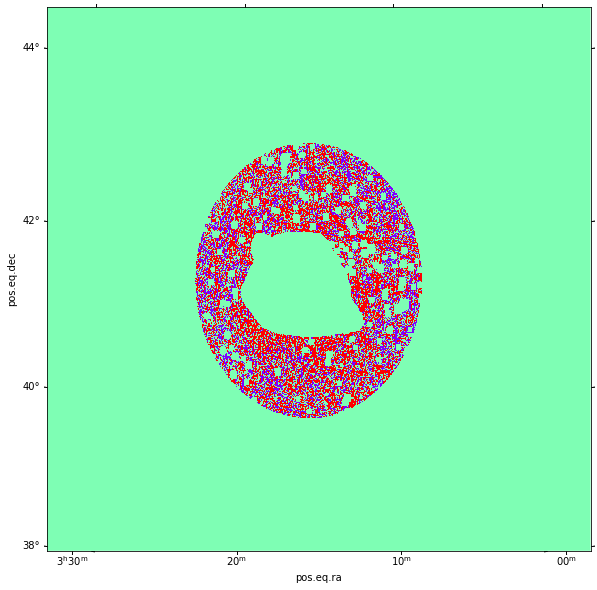

In [377]:
'''plot the residual image'''
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header)) 
ax.imshow(final_residual_wsrt_image, origin='lower', cmap='rainbow_r', vmin=-0.0001, vmax=0.0001)

### applying $\kappa$-$\sigma$ clipping to the image in blocks of 16x16 pixels. Ignoring the masked pixels

In [378]:
from astropy.stats import sigma_clipped_stats

# Define the window size
windowsize = 16
stepsize = 8

downsampled_kappa_sigma_image = np.zeros((int(final_residual_wsrt_image.shape[0]/stepsize),\
                                          int(final_residual_wsrt_image.shape[1]/stepsize)))
# Crop out the window and calculate the histogram
for r_i, r in enumerate(range(0,final_residual_wsrt_image.shape[0] - windowsize, stepsize)):
    for c_i, c in enumerate(range(0,final_residual_wsrt_image.shape[1] - windowsize, stepsize)):
        window = final_residual_wsrt_image[r:r+windowsize,c:c+windowsize]
        # calculate sigma clipping for each block
        block_mean,_,_ = sigma_clipped_stats(window, sigma=2.0, mask_value=0.0)
        downsampled_kappa_sigma_image[r_i, c_i] = block_mean

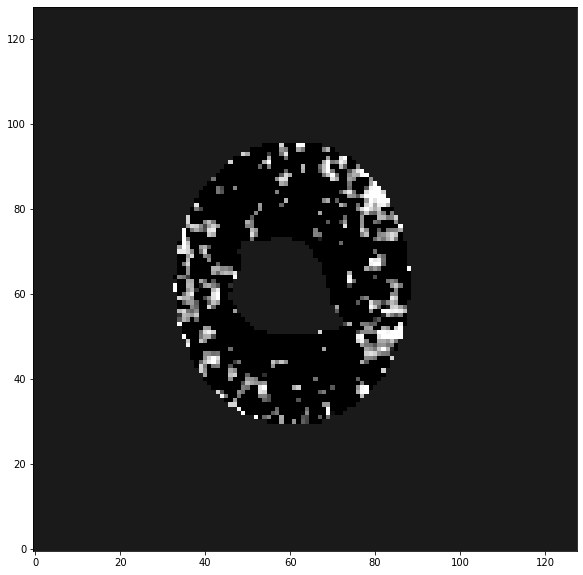

In [379]:
plt.figure( figsize=(12,10))
plt.imshow(downsampled_kappa_sigma_image, origin='lower', cmap='Greys_r', vmin=-0.0001, vmax=0.001)

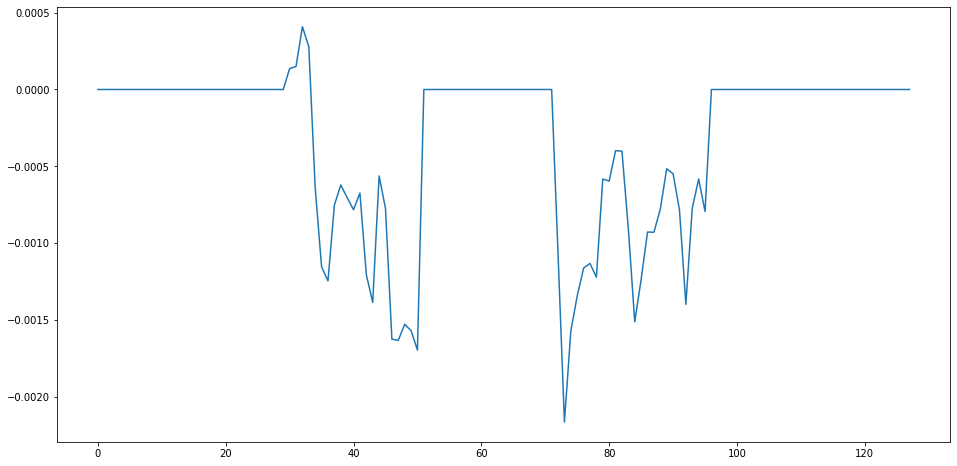

In [382]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(128), downsampled_kappa_sigma_image[:,64])

## Fit 

In [383]:
# Prepare fitting
x = np.arange(0, downsampled_kappa_sigma_image.shape[1], 1)
y = np.arange(0, downsampled_kappa_sigma_image.shape[0], 1)
xx, yy = np.meshgrid(x, y)

final_residual_mask_flat = downsampled_kappa_sigma_image.ravel()
final_residual_wsrt_image_flat = final_residual_mask_flat[final_residual_mask_flat!=0.0]
x_f = xx.ravel()[final_residual_mask_flat!=0.0]
y_f = yy.ravel()[final_residual_mask_flat!=0.0]

In [385]:
x_f, y_f = x_f - 64, y_f - 64

In [386]:
# pred_params, uncert_cov = curve_fit(F, (xx.ravel(), yy.ravel()), final_residual_wsrt_image.ravel())
#                                         #p0=initial_guess, bounds=bounds)
pred_params, uncert_cov = curve_fit(F, (x_f, y_f), final_residual_wsrt_image_flat)
                                        #p0=initial_guess, bounds=bounds)

In [387]:
pred_params

array([ 3.74074732e+03, -5.94637650e+00,  8.51402506e+01, -2.41933568e+03,
        3.66585520e+01, -7.06310147e+02, -7.30955110e+02,  1.05469424e+02,
       -4.74052380e+05,  1.11406586e+06,  9.73017930e+04, -1.57568529e+06,
        1.07899790e+06])

In [388]:
x_b, y_b = xx.ravel(),yy.ravel()
x_b, y_b = x_b - 64, y_b - 64

In [389]:
bowl = F((x_b, y_b), pred_params[0], pred_params[1], pred_params[2], pred_params[3], \
             pred_params[4], pred_params[5], pred_params[6], pred_params[7], \
             pred_params[8], pred_params[9], pred_params[10], pred_params[11], \
             pred_params[12])             

In [390]:
bowl_im = bowl.reshape(128,128)

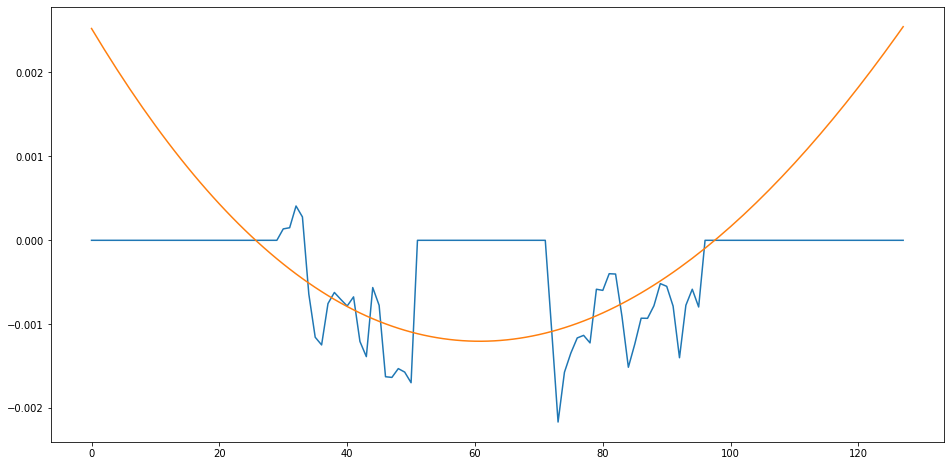

In [391]:
plt.figure(figsize=(16,8))
plt.plot(np.arange(128), downsampled_kappa_sigma_image[:,64])
plt.plot(np.arange(128), bowl_im[:,64])

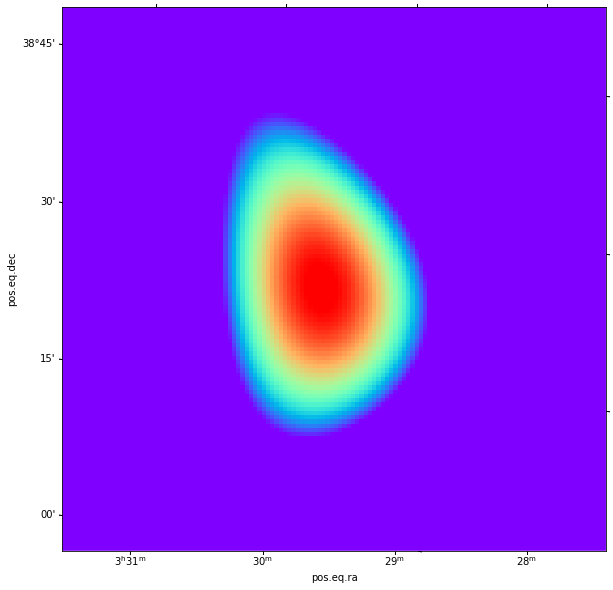

In [392]:
'''plot the bowl image'''
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header))
ax.imshow(bowl_im, origin='lower', cmap='rainbow_r',vmin=-0.0012,vmax=-0.0001)

## Oversampling the fit bowl image back to the original size by padding its FFT with zeros

In [393]:
# upsample the bowl by zero padding the fft of the image
import cv2

bowl_im2 = bowl_im.copy()
bowl_im2[bowl_im2 >= 0.0] = 0.0 
f = np.fft.fft2(bowl_im2)
amp = (1+2*448/128)**2
fshift = np.fft.fftshift(f*amp)

# Create a larger black colored canvas
image = np.zeros((1024, 1024))

image[448:576, 448:576] = fshift

f_ishift = np.fft.ifftshift(image)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

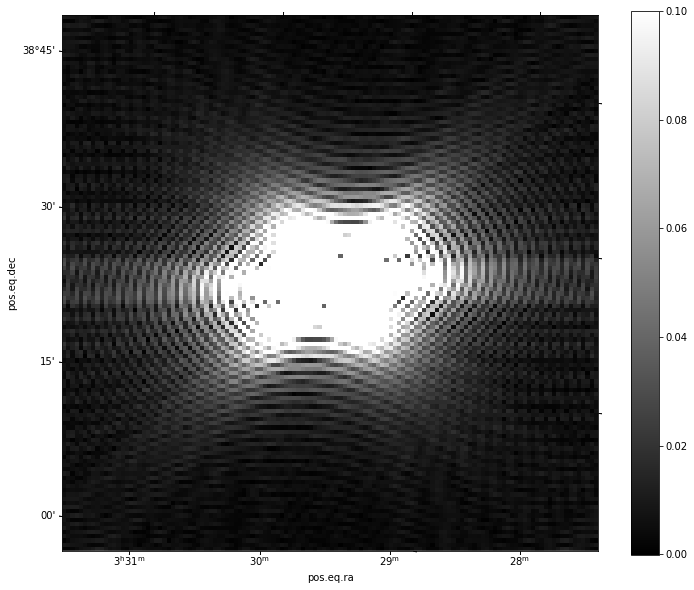

In [399]:
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header))
im = ax.imshow(abs(fshift), origin='lower', cmap='gray',vmin=-0.0001,vmax=0.1)
fig.colorbar(im, orientation='vertical')

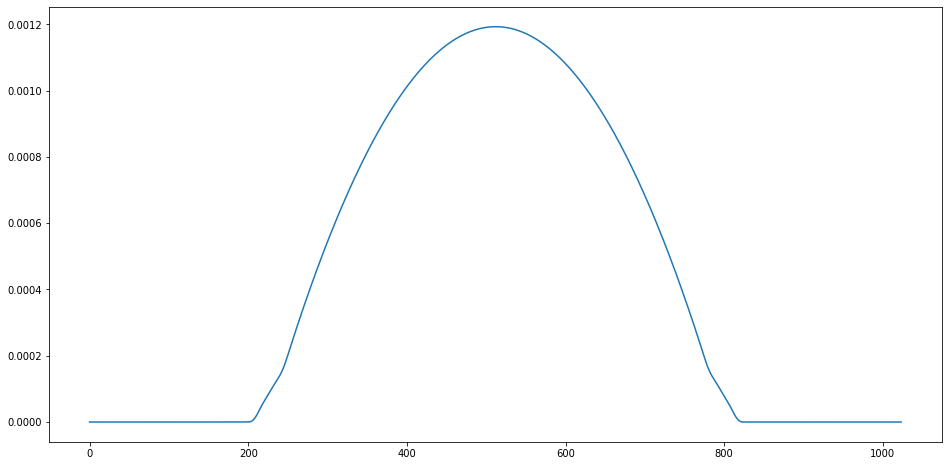

In [400]:
plt.figure(figsize=(16,8))
# plt.plot(np.arange(1024), resized[:,512])
plt.plot(np.arange(1024), img_back[:,512])

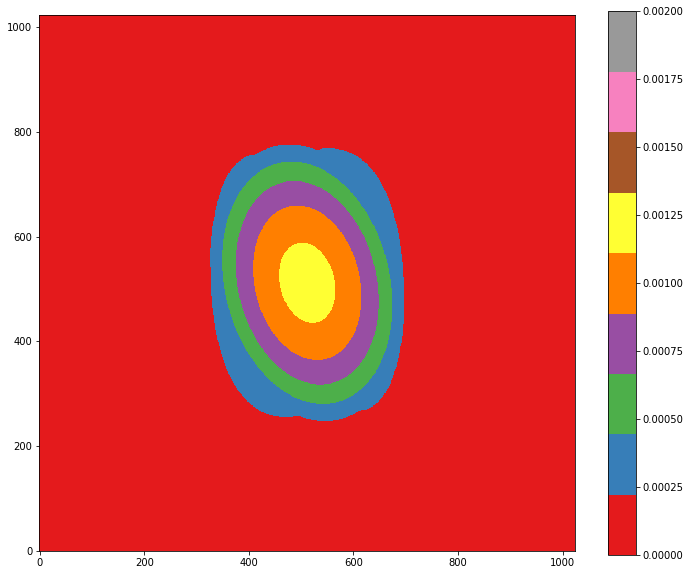

In [401]:
fig, ax = plt.subplots( figsize=(12,10))
# ax= plt.subplot(projection=WCS(wsrthdu[0].header))
im = ax.imshow(img_back, origin='lower', cmap='Set1', vmin=0, vmax=0.002)
fig.colorbar(im, orientation='vertical')
plt.show()

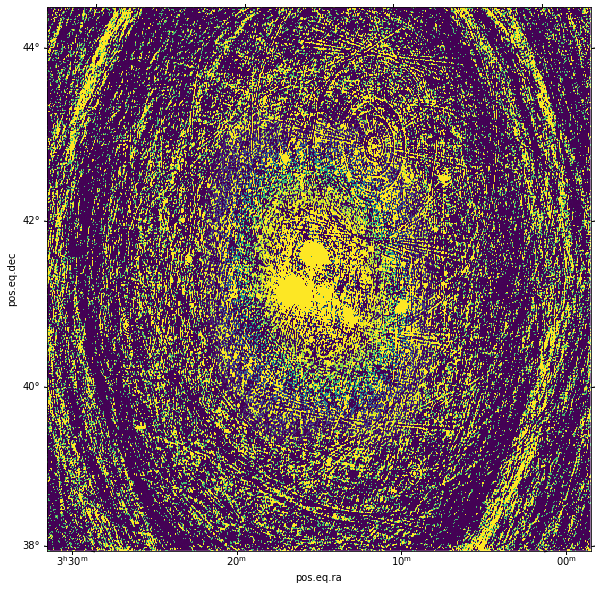

In [402]:
bowl_subtracted_data = wsrthdu[0].data + img_back

'''plot the bowl image'''
fig, ax = plt.subplots( figsize=(12,10))
ax= plt.subplot(projection=WCS(wsrthdu[0].header))
ax.imshow(bowl_subtracted_data, origin='lower', cmap='viridis', vmin=-0.00001, vmax=0.001)

In [403]:
bowl_masked = bowl_im.copy()
bowl_masked[downsampled_kappa_sigma_image==0.0] = 0.0

## residuals after removing the bowl
residuals = downsampled_kappa_sigma_image - bowl_masked

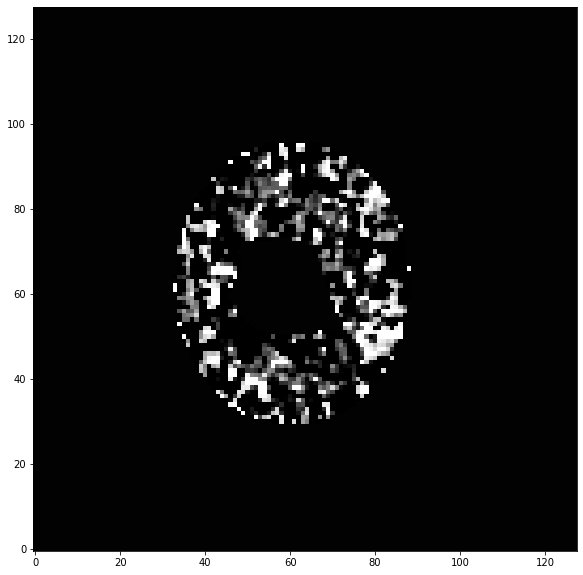

In [404]:
## plot residuals
plt.figure( figsize=(12,10))
plt.imshow(residuals, origin='lower', cmap='Greys_r', interpolation='nearest',vmin=-0.00001, vmax=0.001)

In [405]:
#Save the lofar image matched to wsrt res and open it
ssp_wsrt = './wsrt_ssp_corrected_better_new2.fits'
ssp_hdu = fits.PrimaryHDU (bowl_subtracted_data, header = wsrthdu[0].header)
ssp_hdu.writeto(ssp_wsrt)

In [406]:
#Save the lofar image matched to wsrt res and open it
ssp_wsrt = './wsrt_ssp_estimatedbowl_new2.fits'
ssp_hdu = fits.PrimaryHDU (img_back, header = wsrthdu[0].header)
ssp_hdu.writeto(ssp_wsrt)